In [1]:
import ltn
import tensorflow as tf
import numpy as np
from collections import defaultdict

2023-11-18 23:52:16.005983: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-18 23:52:16.554142: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 23:52:16.554221: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 23:52:16.557919: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 23:52:16.723832: I tensorflow/core/platform/cpu_feature_g

In [2]:
tf.config.run_functions_eagerly(True)

In [3]:
import h5py
imdb = h5py.File('../data/mini_imdb_1024.h5')
sgdb = h5py.File('../data/mini_VG-SGG.h5')

import json
with open('../data/mini_VG-SGG-dicts.json') as f:
    sgdicts = json.load(f)

In [4]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Equiv = ltn.Wrapper_Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.And_Prod(),ltn.fuzzy_ops.Implies_Reichenbach()))
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=6),semantics="exists")

In [5]:
images = ltn.Variable('image', [i for i in range(1000)]) # 1000 images
objects = ltn.Variable('object', [i for i in range(150)]) # 150 objects
subjects = ltn.Variable('subject', [i for i in range(150)]) 
relationships = ltn.Variable('relationship', [i for i in range(50)]) # 50 relationships

2023-11-18 23:53:32.989003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 23:53:33.040302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 23:53:33.040365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 23:53:33.044915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 23:53:33.044992: I tensorflow/compile

In [6]:
in_image = defaultdict(set)
box_in_image = [{} for i in range(1000)]
for image in images.tensor:
    image = int(image[0])
    if sgdb['img_to_first_box'][image] >= 0:
        boxes = [b for b in range(sgdb['img_to_first_box'][image], sgdb['img_to_last_box'][image]+1)]
        in_image[image] = set([sgdb['labels'][b][0] for b in boxes])
        for box in boxes:
            box_in_image[image][sgdb['labels'][box][0]] = box

def object_in_image(args):
    args = tf.stack(args, axis=1)
    output = [0] * args.shape[0]
    for i, arg in enumerate(args):
        object, image = arg
        object, image = int(object), int(image)

        if object in in_image[image]:
            output[i] = 1

    return output

obj_in_img = ltn.Predicate(object_in_image)

In [7]:
related_in_image = [defaultdict(set) for _ in range(len(imdb['images']))]
for image in range(len(imdb['images'])):
    if sgdb['img_to_first_rel'][image] >= 0:
        relations = [i for i in range(sgdb['img_to_first_rel'][image], sgdb['img_to_last_rel'][image]+1)]
        for relation in relations:
            predicate = sgdb['predicates'][relation][0]
            related_objects = tuple([sgdb['labels'][o][0] for o in sgdb['relationships'][relation].tolist()])
            related_in_image[image][predicate].add(related_objects)

def relationship_in_image(args):
    output = []

    for relationship, subject, object, image in zip(*args):
        relationship = int(relationship)
        subject, object = int(subject), int(object)
        image = int(image)

        if (subject, object) in related_in_image[image][relationship]:
            output.append(1)
        else:
            output.append(0)

    return output

rel_in_img = ltn.Predicate(relationship_in_image)

In [12]:
class ModelConnected(tf.keras.Model):
    def __init__(self):
        super(ModelConnected, self).__init__()
        self.dense1 = tf.keras.layers.Dense(8, activation=tf.nn.elu)
        self.dense2 = tf.keras.layers.Dense(16, activation=tf.nn.elu)
        self.dense3 = tf.keras.layers.Dense(32, activation=tf.nn.elu)
        self.dense4 = tf.keras.layers.Dense(16, activation=tf.nn.elu)
        self.dense5 = tf.keras.layers.Dense(8, activation=tf.nn.elu)
        self.dense6 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)

    def call(self, inputs):

        relation, subject, object, distance = inputs 
        x = tf.concat([relation, subject, object, distance], axis=1)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        return self.dense6(x)
    
Connected = ltn.Predicate(ModelConnected())

In [10]:
Connected.model.load_weights('./checkpoints/cp-connected-axioms-deep-inimage-dist')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./checkpoints/cp-connected-axioms-deep-inimage-dist

In [11]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))
negative = True

@tf.function
def axioms():
    axioms = []
    for i in range(len(related_in_image)):
        image = related_in_image[i]
        for relation in image:
            rel = ltn.Constant(relation, trainable=False)
            for subject, object in image[relation]:

                sub = ltn.Constant(subject, trainable=False)
                obj = ltn.Constant(object, trainable=False)

                sx1, sx2, sy1, sy2 = sgdb['boxes_1024'][box_in_image[i][subject]]
                ox1, ox2, oy1, oy2 = sgdb['boxes_1024'][box_in_image[i][object]]
                scenter = (sx1+sx2)/2 + (sy1+sy2)/2
                ocenter = (ox1+ox2)/2 + (oy1+oy2)/2
                dist = ltn.Constant(abs(scenter-ocenter), trainable=False)

                axioms.append(Connected([rel, sub, obj, dist]))

                if negative:
                    for other_relation in image:
                        if other_relation != relation:
                            orel = ltn.Constant(other_relation, trainable=False)
                            axioms.append(Not(Connected([orel, sub, obj, dist])))

    kb = formula_aggregator(axioms)
    sat = kb.tensor
    return sat

axioms()

<tf.Tensor: shape=(), dtype=float32, numpy=0.44253075>

In [14]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
%matplotlib  inline

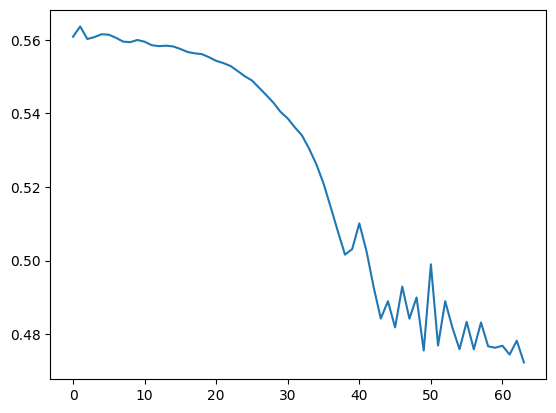

In [19]:
optimizer = tf.optimizers.legacy.Adam(learning_rate=0.001)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
losses = []
for epoch in range(64):
    with tf.GradientTape() as tape:
        loss = 1 - axioms()
        losses.append(loss)

        ax.cla()
        ax.plot(losses)
        display(fig)
        clear_output(wait=True)

        gradients = tape.gradient(loss, Connected.trainable_variables)
        optimizer.apply_gradients(zip(gradients, Connected.trainable_variables))

In [20]:
Connected.model.save_weights('./checkpoints/cp-connected-axioms-deep-inimage-dist')

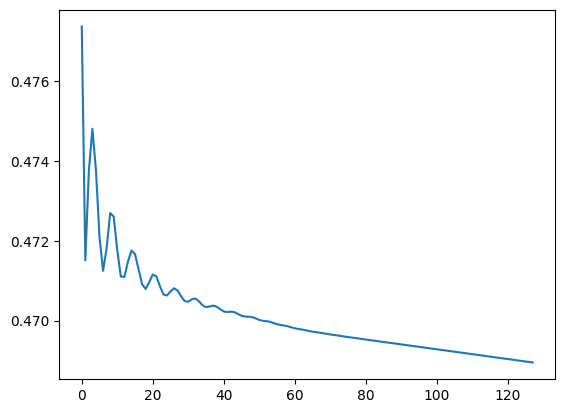

In [21]:
optimizer = tf.optimizers.legacy.Adam(learning_rate=0.0001)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
losses = []
for epoch in range(128):
    with tf.GradientTape() as tape:
        loss = 1 - axioms()
        losses.append(loss)

        ax.cla()
        ax.plot(losses)
        display(fig)
        clear_output(wait=True)

        gradients = tape.gradient(loss, Connected.trainable_variables)
        optimizer.apply_gradients(zip(gradients, Connected.trainable_variables))

In [22]:
Connected.model.save_weights('./checkpoints/cp-connected-axioms-deep-inimage-dist2')

In [23]:
accuracy = 0
relations = len(sgdb['relationships'])
for i in range(len(related_in_image)):
    image = related_in_image[i]
    for relation in image:
        for subject, object in image[relation]:

            sub = ltn.Constant(subject, trainable=False)
            obj = ltn.Constant(object, trainable=False)

            sx1, sx2, sy1, sy2 = sgdb['boxes_1024'][box_in_image[i][subject]]
            ox1, ox2, oy1, oy2 = sgdb['boxes_1024'][box_in_image[i][object]]
            scenter = (sx1+sx2)/2 + (sy1+sy2)/2
            ocenter = (ox1+ox2)/2 + (oy1+oy2)/2
            dist = ltn.Constant(abs(scenter - ocenter), trainable=False)

            prediction = round(tf.argmax(Connected([relationships, sub, obj, dist]).tensor).numpy())

            if prediction == relation:
                accuracy += 1

print(f'ACCURACY: {accuracy / relations}')

ACCURACY: 0.004944375772558714


In [24]:
true_positives = 0
false_positives = 0
relations = len(sgdb['relationships'])
for i in range(len(related_in_image)):
    image = related_in_image[i]
    for relation in image:
        for subject, object in image[relation]:

            sub = ltn.Constant(subject, trainable=False)
            obj = ltn.Constant(object, trainable=False)

            sx1, sx2, sy1, sy2 = sgdb['boxes_1024'][box_in_image[i][subject]]
            ox1, ox2, oy1, oy2 = sgdb['boxes_1024'][box_in_image[i][object]]
            scenter = (sx1+sx2)/2 + (sy1+sy2)/2
            ocenter = (ox1+ox2)/2 + (oy1+oy2)/2
            dist = ltn.Constant(abs(scenter - ocenter), trainable=False)

            prediction = round(tf.argmax(Connected([relationships, sub, obj, dist]).tensor).numpy())

            if prediction == relation:
                true_positives += 1
            else:
                false_positives += 1

print(f'PRECISION: {true_positives / (true_positives+false_positives)}')

PRECISION: 0.007309941520467836
